# Use obspy to download some data to work with

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import sys
sys.path.append("..")
import splitwavepy as sw

import scipy
import math
import numpy as np
import matplotlib.pyplot as plt




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


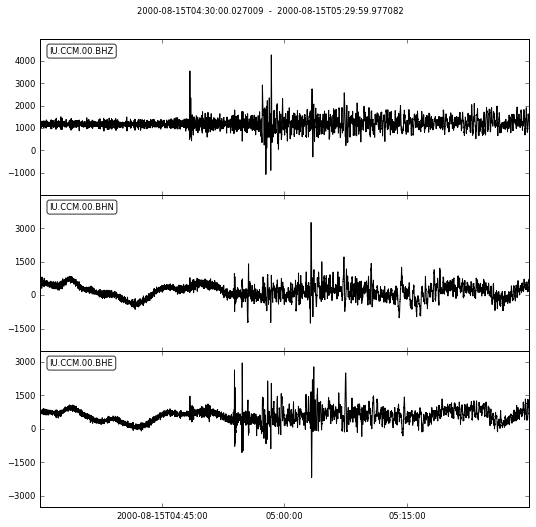

In [2]:
# Get waveforms of event plotted in my G3,2014 paper 
# (I discovered that I got the event time wrong in the paper -- but this is correct.)
from obspy import read
from obspy.clients.fdsn import Client
# from obspy.clients.iris import Client
client = Client("IRIS")
from obspy import UTCDateTime
t = UTCDateTime("2000-08-15T04:30:0.000")
st = client.get_waveforms("IU", "CCM", "00", "BH?", t, t + 60 * 60,attach_response=True)
st.plot() 

In [3]:
# get event information
lat=-31.56
lon=179.74
# server does not accept longitude greater than 180.
cat = client.get_events(starttime=t-60,endtime=t+60,minlatitude=lat-1,
                  maxlatitude=lat+1,minlongitude=lon-1,maxlongitude=180)
evtime = cat.events[0].origins[0].time
evdepth = cat.events[0].origins[0].depth/1000
evlat = cat.events[0].origins[0].latitude
evlon = cat.events[0].origins[0].longitude

# station information
inventory = client.get_stations(network="IU",station="CCM",starttime=t-60,endtime=t+60)
stlat = inventory[0][0].latitude
stlon = inventory[0][0].longitude

# find arrival times
from obspy.taup import TauPyModel
model = TauPyModel('iasp91')
arrivals = model.get_travel_times_geo(evdepth,evlat,evlon,stlat,stlon,phase_list=['SKS'])
skstime = evtime + arrivals[0].time

# ray geometry
from obspy import geodetics
dist,az,baz = geodetics.base.gps2dist_azimuth(evlat,evlon,stlat,stlon)
inc = arrivals[0].incident_angle

In [4]:
# Get data around SKS
data = st.copy()
data.filter("bandpass",freqmin=0.01,freqmax=.5)
data.trim(skstime-30,skstime+30)
delta = data[0].stats.delta

# Pair

## EigenValue Method

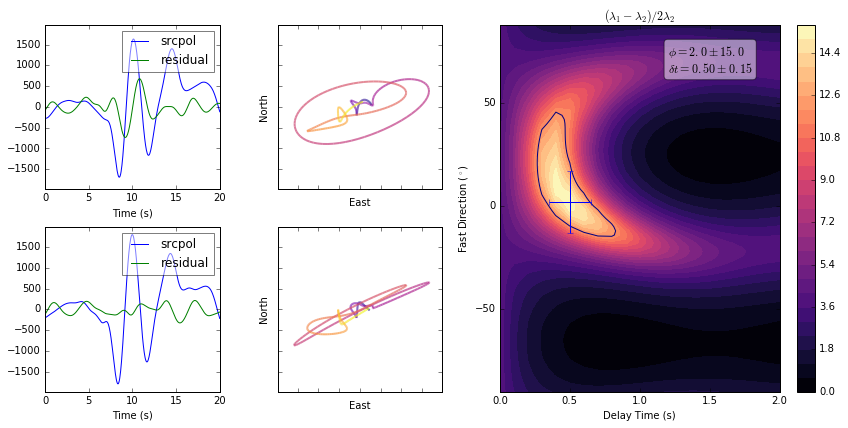

In [8]:
p = sw.Pair(data[1].data, data[0].data, delta=delta)
A = sw.EigenM(p,lags=(2,))
A.plot()

## Transverse Energy Method

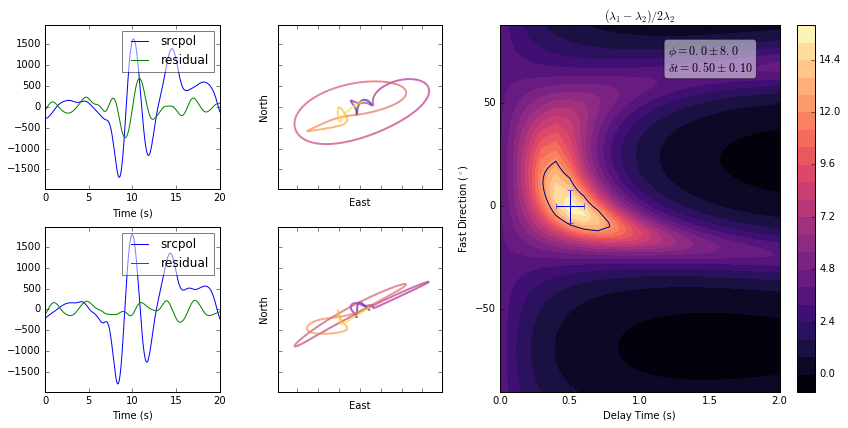

In [9]:
B = sw.TransM(p, pol=baz, lags=(2,))
B.plot()

## Rotation Correlation Method

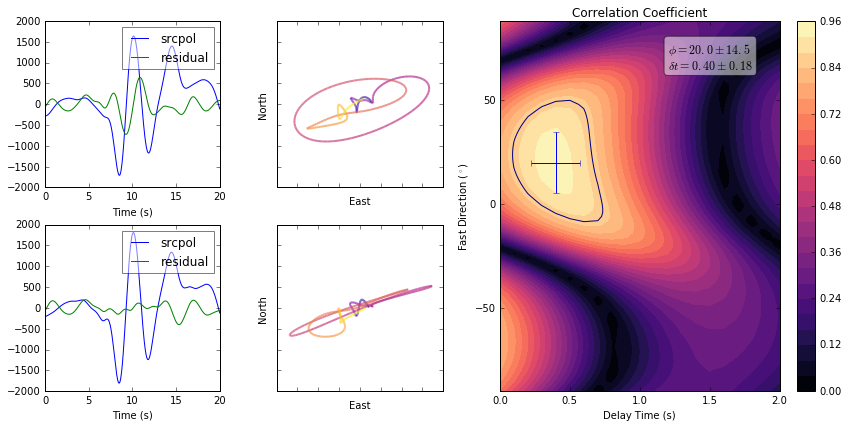

In [10]:
C = sw.CrossM(p, lags=(2,))
C.plot()

# Q

In [12]:
def Q(fastev,lagev,fastrc,lagrc):
    """Following Wuestefeld et al. 2010"""
    omega = math.fabs((fastev - fastrc + 3645)%90 - 45) / 45
    delta = lagrc / lagev
    dnull = math.sqrt(delta**2 + (omega-1)**2) * math.sqrt(2)
    dgood = math.sqrt((delta-1)**2 + omega**2) * math.sqrt(2)
    if dnull < dgood:
        return -(1 - dnull)
    else:
        return (1 - dgood)

In [13]:
Q(A.fast,A.lag,C.fast,C.lag)

0.3675444679663241

# Trio

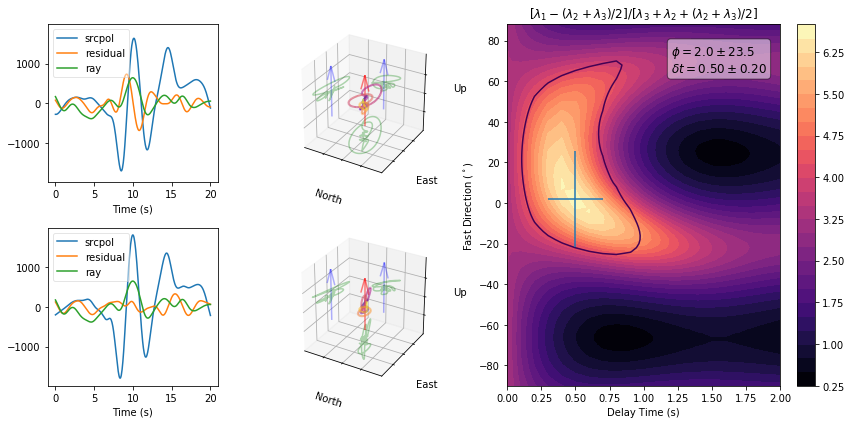

In [7]:
# Assume Vertical Ray
t = sw.Trio(data.traces[1].data, data.traces[0].data, data.traces[2].data, delta=delta)
m = sw.Eig3dM(t,lags=(2,))
m.plot()

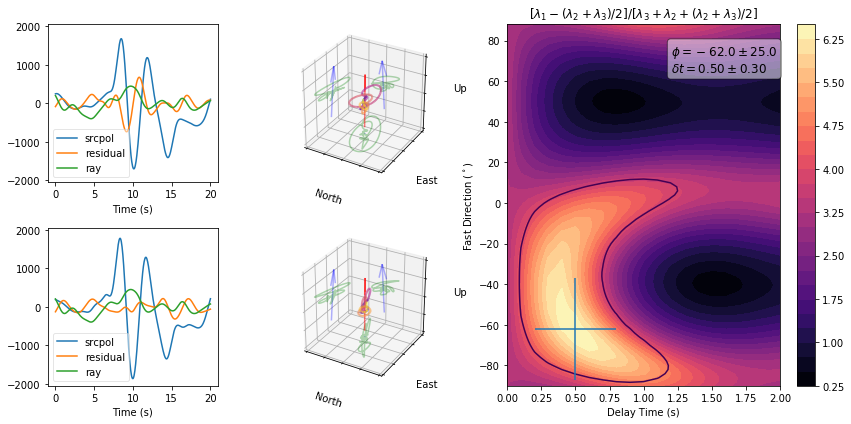

In [8]:
# Calculate ray from source-receiver geometry

t = sw.Trio(data.traces[1].data, data.traces[0].data, data.traces[2].data, delta=delta, ray=(baz+180,inc))
m = sw.Eig3dM(t,lags=(2,))
m.plot()

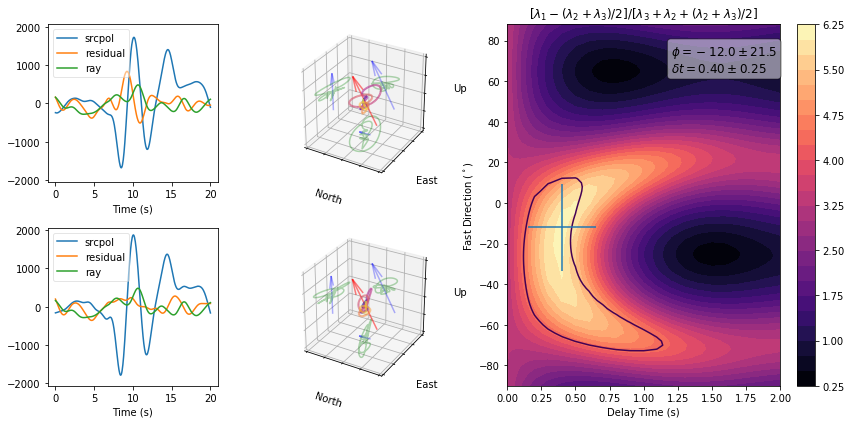

In [9]:
# Data determined ray
t = sw.Trio(data.traces[1].data, data.traces[0].data, data.traces[2].data, delta=delta)
t.set_ray()
m = sw.Eig3dM(t,lags=(2,))
m.plot()

In [ ]:

t.set_ray()
m = sw.Eig3dM(t,lags=(2,))
m.plot()

In [ ]:
# Radial-Transverse Traces
strt = stf.select(component="[N,E]").copy()
strt.rotate("NE->RT",back_azimuth=baz)
# strt.plot()
e = strt.copy()
e.trim(skstime-30,skstime+30)
# e.plot()
q = s.Pair(e[0].data,e[1].data,delta=delta)
N = s.EigenM(q)
N.plotsurf(cmap='magma')

In [ ]:
data.traces[1].data

In [ ]:
stne = stf.select(component="[E,N]").copy()
stne.trim(skstime-30,skstime+30)
delta = stne[0].stats.delta

tlags = np.linspace(0,2.0,40)
# degs = np.linspace(-90,90,90)
M = s.EigenM(stne[1].data,stne[0].data,delta=delta,tlags=tlags)
# M = s.EigenM(stne[1],stne[0],delta=delta)
M.plotsurf(lam2_95=True)
M.f_errors()

# Width of confidence contour

In [ ]:
c = plt.contour(M.tlags,M.degs,M.lam2,levels=[M.lam2_95()])
p = c.collections[0].get_paths()
v = np.asarray([ v.vertices for v in p ])[0]
# bounding rectangle
print('dfast:',(v[:,1].max() - v[:,1].min())/4)
print('dtlag:',(v[:,0].max() - v[:,0].min())/4)

In [ ]:
tlags = np.linspace(0,2.0,40)
M = s.EigenM(stne[1].data,stne[0].data,delta=delta,tlags=tlags)
M.lam2 = np.roll(M.lam2,30,axis=1)
c = plt.contour(M.tlags,M.degs,M.lam2,levels=[M.lam2_95()])
p = c.collections[0].get_paths()
v = np.vstack([ v.vertices for v in p ])
# bounding rectangle
print('dfast:',(v[:,1].max() - v[:,1].min())/4)
print('dtlag:',(v[:,0].max() - v[:,0].min())/4)

In [ ]:
critval=M.lam2_95()
fastax = (M.lam2 <= critval).any(axis=0)
tlagax = (M.lam2 <= critval).any(axis=1)

In [ ]:
M.f_errors()

In [ ]:
confbool = M.lam2 <= M.lam2_95()
tlagbool = confbool.any(axis=1)
truth = np.where(tlagbool)[0]
dtlag = (truth[-1] - truth[0] + 1) * tlag_step * 0.25   

# fast error
fastbool = confbool.any(axis=0)
# trickier to handle due to cyclicity of angles
# search for the longest continuous line of False values
cyclic = np.hstack((fastbool,fastbool))
lengthFalse = np.diff(np.where(cyclic)).max()
# shortest line that contains ALL true values is then:
lengthTrue = fastbool.size - lengthFalse
dfast = lengthTrue * fast_step * 0.25 

In [ ]:
M.tlags[1,0]-M.tlags[0,0]

In [ ]:
M.degs[0,1]-M.degs[0,0]

In [ ]:
data[1].data.size

In [ ]:
data[1].stats.delta